### First stab at ACH data

In [1]:
import pandas as pd
import numpy as np
import category_encoders
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
%time transactions_df = pd.read_feather('../data/features/features_1595522161.feather')
%time df = pd.read_feather('../data/labeled_new_features/label_new_features_1596581849.feather')
df.head()

CPU times: user 16.6 s, sys: 16.6 s, total: 33.3 s
Wall time: 8.09 s
CPU times: user 706 ms, sys: 326 ms, total: 1.03 s
Wall time: 239 ms


,index,transaction_datetime,user_id,business_account_number,transaction_code,is_return,transaction_amount,endbal,external_account_number,real_ending_balance,...,bal_after_90d,tamt_abs,is_returned,target,indeterminate,nr_transactions_per_day,rolling_mean_acc_bal,rolling_trns_as_pct_of_bal,transaction_as_pct_of_bal_min,transaction_as_pct_of_balance_abs
0,0,2017-12-13 16:26:31,65740,410000007044,ACHDD,0.0,500.0,500.000000,80001475699,500.000000,...,2386.239990,500.0,False,False,False,NaN,500.000000,NaN,NaN,inf
1,31,2018-01-04 18:43:31,65740,410000007044,ACHDD,0.0,75.0,558.289978,80001475699,558.289978,...,3887.729980,75.0,False,False,False,1.409091,489.379412,0.019838,-0.000972,0.155186
2,46,2018-01-24 20:14:12,65740,410000007044,ACHDD,0.0,100.0,520.270020,80001475699,520.270020,...,903.400024,100.0,False,False,False,1.095238,470.270000,0.073134,-0.093423,0.237942
3,47,2018-01-26 10:53:36,65740,410000007044,ACHDD,0.0,125.0,645.270020,80001475699,645.270020,...,903.400024,125.0,False,False,False,1.093023,483.731538,0.088327,-0.093423,0.240260
4,49,2018-01-27 12:10:55,65740,410000007044,ACHDD,0.0,150.0,794.770020,80001475699,794.770020,...,1400.270020,150.0,False,False,False,1.113636,512.270000,0.092693,-0.093423,0.232641


In [3]:
df['target'].value_counts()

False    544946
True      14519
Name: target, dtype: int64

In [4]:
df['business_account_number'].nunique()

133365

is_returned
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: transaction_datetime, dtype: object

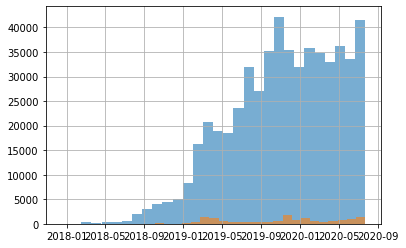

In [38]:
df.groupby('is_returned')['transaction_datetime'].hist(bins=30, alpha=0.6)

In [5]:
# We are taking the dataframe from 2019-1-16 to 2020-02-14 for training
modeling_df = df[df['transaction_datetime'].between(pd.to_datetime('2019-01-16'), 
                                                    pd.to_datetime('2020-02-14'))]

In [33]:
len(modeling_df) / len(df)

0.6249059369218807

In [6]:
modeling_df[['indeterminate', 'target']].value_counts()

indeterminate  target
False          False     339527
True           True        5169
False          True        4917
dtype: int64

In [7]:
modeling_df['chg_wrt_off_date'].isna().value_counts()

True     345593
False      4020
Name: chg_wrt_off_date, dtype: int64

In [8]:
# accounts have been charged off
modeling_df['closed_by_risk_or_chg_off'] = (~modeling_df['chg_wrt_off_date'].isna()) | \
    modeling_df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                       'Closed by SoFi - Charge-Off / Write-Off'])

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
modeling_df.closed_by_risk_or_chg_off.value_counts()

False    339739
True       9874
Name: closed_by_risk_or_chg_off, dtype: int64

#### target definition

``` df['target'] = df['is_returned'] & (df['bal_after_90d'] > 0)```

In [10]:
# accounts that has been charged off but is not in our target definition
(~modeling_df['target'] & modeling_df['closed_by_risk_or_chg_off']).value_counts()

False    344431
True       5182
dtype: int64

In [11]:
# accounts that has been charged off and is something model is trying to classify
(modeling_df['target'] & modeling_df['closed_by_risk_or_chg_off']).value_counts()

False    344921
True       4692
dtype: int64

In [12]:
# target with positive balance after 90 days and wasn't closed by risk
(modeling_df['target'] & (modeling_df['bal_after_90d'] >= 0) & ~modeling_df['closed_by_risk_or_chg_off']).value_counts()

False    344241
True       5372
dtype: int64

In [13]:
'''
indetermindate_ when
1. closed by risk but no ach return -> maybe check return?
2. is ach return but has positive balance after 90 days, and not been charged off

in data.py
indeterminate when
is ach return but balance after 90 days is positive and not charged off by risk
'''
modeling_df['indeterminate_'] = (~modeling_df['target'] & modeling_df['closed_by_risk_or_chg_off']) \
    | (modeling_df['target'] & (modeling_df['bal_after_90d'] >= 0) & ~modeling_df['closed_by_risk_or_chg_off'])

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
(modeling_df['indeterminate'] == modeling_df['indeterminate_']).all()

False

#### Statistics for indeterminate

In [24]:
# if we 
# modeling_df['indeterminate_'] = modeling_df['is_returned'] & (modeling_df['bal_after_90d'] > 0)
# modeling_df[['target', 'indeterminate_']].value_counts()
modeling_df['target_'] = modeling_df['is_returned'] & (modeling_df['bal_after_90d'] <= 0)
modeling_df['target_'].value_counts()

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


False    344696
True       4917
Name: target_, dtype: int64

In [20]:
modeling_df['target_'] = modeling_df['is_returned'] & (modeling_df['bal_after_90d'] <= 0 | 
                                                       modeling_df['closed_by_risk_or_chg_off'])
modeling_df['target_'].value_counts()

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


False    344032
True       5581
Name: target_, dtype: int64

##### Distributions

array([[<AxesSubplot:title={'center':'transaction_counts'}>]],
      dtype=object)

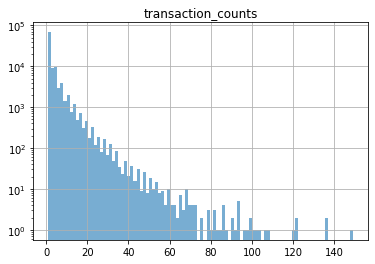

In [8]:
by_account = modeling_df[['business_account_number', 'target']].groupby('business_account_number').count()
by_account.columns = ['transaction_counts']
by_account.hist(bins=100, log=True, alpha=0.6)

In [9]:
by_account.sort_values('transaction_counts', ascending=False).head(10)

,transaction_counts
business_account_number,
410000146203,149
410001105717,137
410001583241,136
410001384074,122
410000145260,121
410000100809,120
410000095355,109
410000216977,107
410000322061,104


In [96]:
by_account = modeling_df[['business_account_number', 'target']]\
        .groupby('business_account_number')['target'].agg(['mean', 'count'])
by_account.columns = ['pct_returns', 'nr_transactions_tot']
by_account.sort_values('pct_returns', ascending=False, inplace=True)

In [111]:
# how many returned happend on the first transaction?
one_transaction = by_account[(by_account.nr_transactions_tot == 1) 
                             & (by_account.pct_returns > 0)]
mult_transaction = by_account[(by_account.nr_transactions_tot > 1) 
                             & (by_account.pct_returns > 0)]

In [114]:
print(one_transaction.shape, mult_transaction.shape, by_account[by_account.pct_returns > 0].shape)

((3250, 2), (4051, 2), (7301, 2))

<AxesSubplot:>

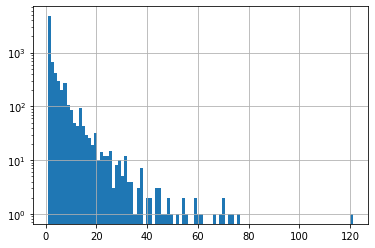

In [121]:
by_account[by_account.pct_returns > 0].nr_transactions_tot.hist(bins=100, log=True, label='distr or nr_returns by acct')

##### Check them out individually

In [10]:
pii_cols = ['borrower_id''date_of_birth', 
             'first_name', 'last_name', 'current_addr_line_1']
meta_cols = ['borrower_id', 'user_id', 'sofi_employee_ind']
transactions_cols = ['user_id', 'business_account_number', 'transaction_datetime', 
                     'transaction_code', 'is_return', 'transaction_amount', 
                     'endbal', 'external_account_number', 'real_ending_balance', 
                     'external_account_number', 'external_institution_id',
                     'originating_company_id', 'external_institution_trans_id',
                     'originator_dfi_id']
ecp_cols = ['user_id', 'credit_pull_date', 'fico_score', 'vantage_score', 'all7120',
            'all8220', 'bcc2800', 'bcc7120', 'bcx3423', 'iln5520', 'iqt9413', 
            'iqt9415', 'mtf5820', 'stu5031', 'credit_card_loan_amount', 'delinquencies_90_days',
            'education_loan_amount', 'mortgage_loan_amount', 'secured_loan_amount', 
            'total_outstanding_balance', 'total_tradelines_open', 'unsecured_loan_amount']
giact_cols = ['business_account_number', 'giact_created_date', 'giact_first_link_date', 
              'giact_last_link_date', 'giact_is_pass', 'giact_is_decline', 
              'giact_is_other', 'giact_nr_pass', 'giact_nr_decline',
              'giact_nr_other']
quovo_cols = ['user_id', 'quovo_first_link_date',
              'quovo_last_link_date', 'quovo_max_avail_bal',
              'quovo_min_avail_bal', 'quovo_total_pos_bal', 
              'quovo_total_neg_bal', 'quovo_largest_checking_or_savings_balance', 
              'quovo_available_bal']
plaid_cols = ['user_id', 'plaid_first_link_date',
              'plaid_last_link_date', 'plaid_max_avail_bal',
              'plaid_min_avail_bal', 'plaid_total_pos_bal', 
              'plaid_total_neg_bal', 'plaid_largest_checking_or_savings_balance', 
              'plaid_available_bal']
socure_cols = ['user_id', 'fraud_score_1', 'fraud_score_2', 
               'address_risk_score', 'email_risk_score', 'phone_risk_score', 
               'name_address_correlation', 'name_email_correlation', 
               'name_phone_correlation', 'nr_social_profiles_found']
important_features = []
cols_by_type = [meta_cols, transactions_cols, ecp_cols, 
                giact_cols, quovo_cols, plaid_cols, socure_cols]

In [11]:
print(transactions_df.shape)
transactions_df.head()

(12649150, 158)


,user_id,business_account_number,transaction_datetime,transaction_code,is_return,transaction_amount,endbal,external_account_number,real_ending_balance,external_institution_id,...,bal_ratio,deposits_ratio,is_dd,nr_direct_deposits,dd_dollar_amount,dollar_val_dd,nr_transactions_all_time,first_return_date,chg_wrt_off_date,nr_returns_all_time
0,65740,410000007044,2017-12-13 16:26:31,ACHDD,False,500.00,500.00,80001475699,500.00,321081669,...,1.000000,1.00000,False,0.0,0.0,0.0,2401,2018-01-16 10:22:49,NaT,1.0
1,65740,410000007044,2017-12-19 23:55:20,ACHDDIN,False,0.04,500.04,,500.04,,...,1.000040,0.00008,False,0.0,0.0,0.0,2401,2018-01-16 10:22:49,NaT,1.0
2,65740,410000007044,2017-12-19 23:55:20,ACHDDIN,False,0.10,500.14,,500.14,,...,1.000060,0.00028,False,0.0,0.0,0.0,2401,2018-01-16 10:22:49,NaT,1.0
3,65740,410000007044,2017-12-19 23:55:20,ACHDDIN,False,0.10,500.24,,500.24,,...,1.000070,0.00048,False,0.0,0.0,0.0,2401,2018-01-16 10:22:49,NaT,1.0
4,65740,410000007044,2017-12-19 23:55:20,ACHDDIN,False,0.02,500.26,,500.26,,...,1.000068,0.00052,False,0.0,0.0,0.0,2401,2018-01-16 10:22:49,NaT,1.0


In [66]:
user_id = 410003723839
user_transactions = transactions_df[transactions_df.business_account_number == user_id]
user_ach = df[df.business_account_number == user_id]

In [72]:
def generate_user_report(user_df):
    df = user_df.set_index('transaction_datetime')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,8))
    ax1.plot(df.transaction_amount, label='transaction_amount')
    ax2.plot(df.real_ending_balance, label='real_ending_balance')
    
    t_code = df.transaction_code.value_counts()
    ax3.bar(t_code.index, t_code.values, label='transaction_code')
    

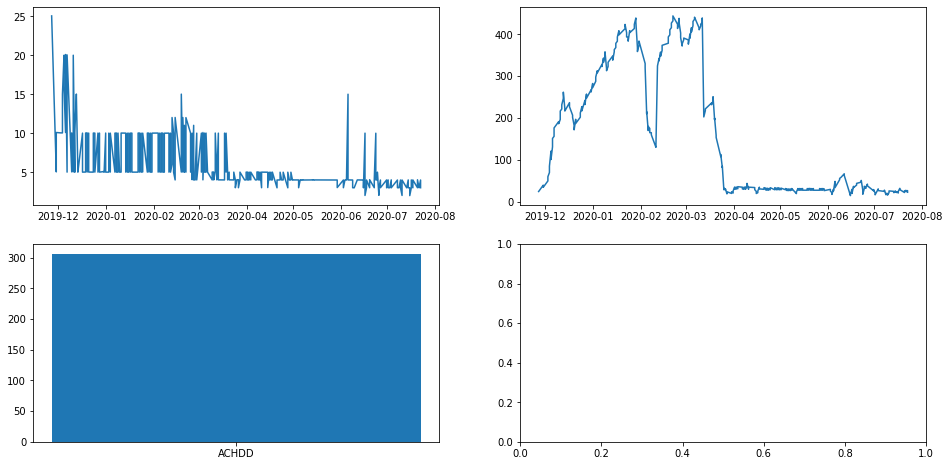

In [73]:
generate_user_report(user_ach)

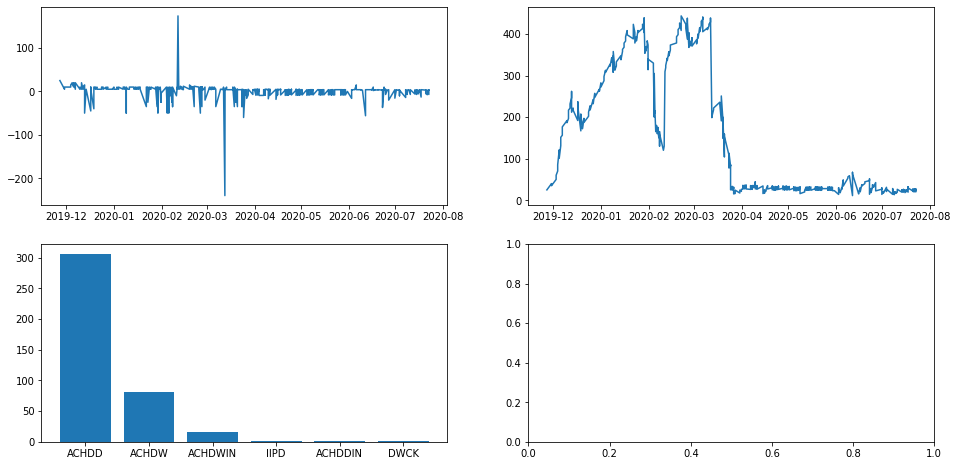

In [71]:
generate_user_report(user_transactions)

In [69]:
for cols in cols_by_type:
    display(user_ach[cols])

,borrower_id,user_id,sofi_employee_ind
472827,8880524,15066335,0.0
472828,8880524,15066335,0.0
472829,8880524,15066335,0.0
472830,8880524,15066335,0.0
472831,8880524,15066335,0.0
...,...,...,...
473129,8880524,15066335,0.0
473130,8880524,15066335,0.0
473131,8880524,15066335,0.0
473132,8880524,15066335,0.0


,user_id,business_account_number,transaction_datetime,transaction_code,is_return,transaction_amount,endbal,external_account_number,real_ending_balance,external_account_number,external_institution_id,originating_company_id,external_institution_trans_id,originator_dfi_id
472827,15066335,410003723839,2019-11-26 18:01:08,ACHDD,0.0,25.049999,25.049999,0202028491,25.049999,0202028491,041201143,,,
472828,15066335,410003723839,2019-11-29 18:01:12,ACHDD,0.0,5.050000,40.200001,0202028491,40.200001,0202028491,041201143,,,
472829,15066335,410003723839,2019-11-29 18:01:12,ACHDD,0.0,10.100000,35.150002,0202028491,35.150002,0202028491,041201143,,,
472830,15066335,410003723839,2019-12-02 18:01:16,ACHDD,0.0,10.050000,50.259998,0202028491,50.259998,0202028491,041201143,,,
472831,15066335,410003723839,2019-12-02 18:01:16,ACHDD,0.0,10.050000,60.310001,0202028491,60.310001,0202028491,041201143,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473129,15066335,410003723839,2020-07-20 18:01:31,ACHDD,0.0,4.040000,26.690001,0202028491,26.690001,0202028491,041201143,,,
473130,15066335,410003723839,2020-07-21 18:01:31,ACHDD,0.0,3.020000,27.740000,0202028491,27.740000,0202028491,041201143,,,
473131,15066335,410003723839,2020-07-21 18:01:31,ACHDD,0.0,3.030000,24.719999,0202028491,24.719999,0202028491,041201143,,,
473132,15066335,410003723839,2020-07-22 18:01:29,ACHDD,0.0,4.010000,27.270000,0202028491,27.270000,0202028491,041201143,,,


,user_id,credit_pull_date,fico_score,vantage_score,all7120,all8220,bcc2800,bcc7120,bcx3423,iln5520,...,mtf5820,stu5031,credit_card_loan_amount,delinquencies_90_days,education_loan_amount,mortgage_loan_amount,secured_loan_amount,total_outstanding_balance,total_tradelines_open,unsecured_loan_amount
472827,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0
472828,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0
472829,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0
472830,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0
472831,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473129,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0
473130,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0
473131,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0
473132,15066335,2019-11-22,677.0,732.0,90.0,352.0,0.0,35.0,0.0,4750.0,...,1162.0,1.000000e+09,4027.0,0.0,0.0,141763.0,0.0,149394.0,15.0,0.0


,business_account_number,giact_created_date,giact_first_link_date,giact_last_link_date,giact_is_pass,giact_is_decline,giact_is_other,giact_nr_pass,giact_nr_decline,giact_nr_other
472827,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0
472828,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0
472829,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0
472830,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0
472831,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
473129,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0
473130,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0
473131,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0
473132,410003723839,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,2019-11-22 23:57:40.963,True,False,False,1.0,0.0,0.0


,user_id,quovo_first_link_date,quovo_last_link_date,quovo_max_avail_bal,quovo_min_avail_bal,quovo_total_pos_bal,quovo_total_neg_bal,quovo_largest_checking_or_savings_balance,quovo_available_bal
472827,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
472828,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
472829,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
472830,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
472831,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
473129,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
473130,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
473131,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
473132,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


,user_id,plaid_first_link_date,plaid_last_link_date,plaid_max_avail_bal,plaid_min_avail_bal,plaid_total_pos_bal,plaid_total_neg_bal,plaid_largest_checking_or_savings_balance,plaid_available_bal
472827,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
472828,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
472829,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
472830,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
472831,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
473129,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
473130,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
473131,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
473132,15066335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


,user_id,fraud_score_1,fraud_score_2,address_risk_score,email_risk_score,phone_risk_score,name_address_correlation,name_email_correlation,name_phone_correlation,nr_social_profiles_found
472827,15066335,0.021606,0.281006,0.065002,0.088989,0.371094,0.909668,0.996094,0.998535,1.0
472828,15066335,0.021606,0.281006,0.065002,0.088989,0.371094,0.909668,0.996094,0.998535,1.0
472829,15066335,0.021606,0.281006,0.065002,0.088989,0.371094,0.909668,0.996094,0.998535,1.0
472830,15066335,0.021606,0.281006,0.065002,0.088989,0.371094,0.909668,0.996094,0.998535,1.0
472831,15066335,0.021606,0.281006,0.065002,0.088989,0.371094,0.909668,0.996094,0.998535,1.0
...,...,...,...,...,...,...,...,...,...,...
473129,15066335,0.019608,0.213013,0.065002,0.101013,0.460938,0.909668,0.995117,0.998535,0.0
473130,15066335,0.019608,0.213013,0.065002,0.101013,0.460938,0.909668,0.995117,0.998535,0.0
473131,15066335,0.019608,0.213013,0.065002,0.101013,0.460938,0.909668,0.995117,0.998535,0.0
473132,15066335,0.019608,0.213013,0.065002,0.101013,0.460938,0.909668,0.995117,0.998535,0.0


indeterminate  target
False          False     544946
True           True        7744
False          True        6775
dtype: int64